In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch
torch.__version__

'2.2.1+cu121'

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**total number of images**

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/data_vit/split_dataset/train'
test_dir = '/content/drive/MyDrive/data_vit/split_dataset/test'


Mounted at /content/drive


**COUNTING NUMBER OF FILES**

In [ ]:
import os

# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/data_vit/split_dataset/train'
test_dir = '/content/drive/MyDrive/data_vit/split_dataset/test'

# Function to count files in a directory
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Count files in train and test directories
train_count = count_files(train_dir)
test_count = count_files(test_dir)
# val_count = count_files(val_dir)

# total number of images
total_count = train_count + test_count

print(f"Total number of images in train directory: {train_count}")
print(f"Total number of images in test directory: {test_count}")
# print(f"Total number of images in test directory: {val_count}")
print(f"Total number of images in both directories: {total_count}")


Total number of images in train directory: 3528
Total number of images in test directory: 882
Total number of images in both directories: 4410


# Create Datasets and DataLoaders

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names



In [ ]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    # val_dir=val_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x784aff66b3d0>,
 ['agricultural',
  'airplane',
  'baseballdiamond',
  'beach',
  'buildings',
  'chaparral',
  'denseresidential',
  'forest',
  'freeway',
  'golfcourse',
  'harbor',
  'intersection',
  'mediumresidential',
  'mobilehomepark',
  'overpass',
  'parkinglot',
  'river',
  'runway',
  'sparseresidential',
  'storagetanks',
  'tenniscourt'])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([3, 224, 224]) tensor(1)


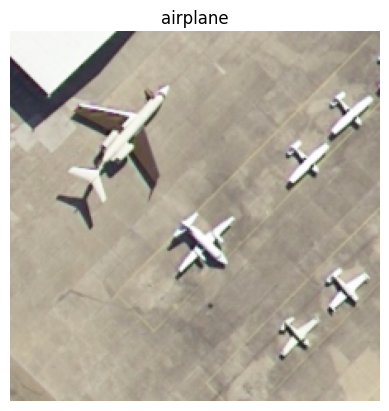

In [ ]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);


1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C)       #Current shape: (1, 768, 196)

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

**sample images in patches**

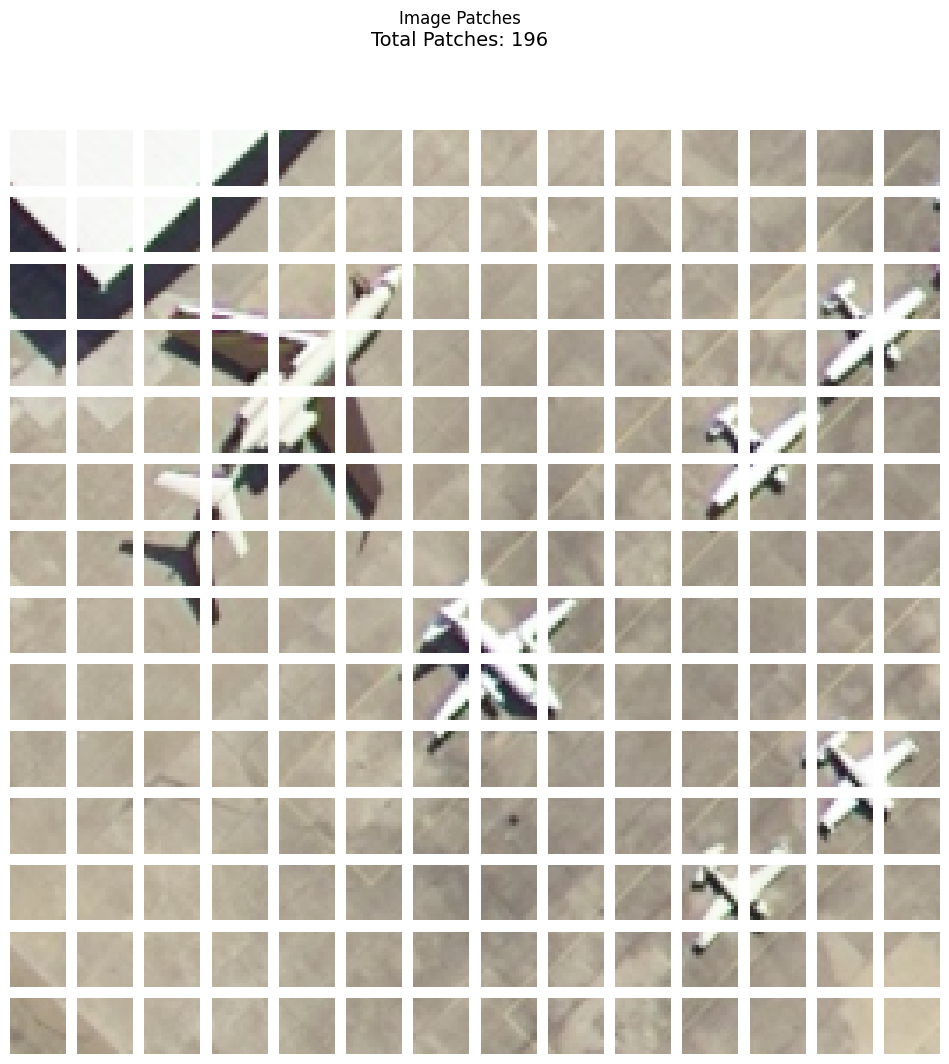

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assume img is your input image tensor
img = image.unsqueeze(0)  # Use the image from the provided code snippet
patch_size = 16  # Set the patch size

# Calculate the number of patches in each dimension
num_patches_h = img.shape[2] // patch_size
num_patches_w = img.shape[3] // patch_size
total_patches = num_patches_h * num_patches_w

# Plot each patch separately
plt.figure(figsize=(12, 12))
for i in range(num_patches_h):
    for j in range(num_patches_w):
        patch = img[:, :, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]  # Extract the patch
        plt.subplot(num_patches_h, num_patches_w, i * num_patches_w + j + 1)
        plt.imshow(patch.squeeze().permute(1, 2, 0).detach().numpy())  # Plot the patch
        # plt.title(f"Patch {i * num_patches_w + j + 1}")
        plt.axis('off')

# Add total number of patches above the visualization
plt.figtext(0.5, 0.95, f"Total Patches: {total_patches}", ha="center", fontsize=14)

plt.suptitle("Image Patches")
plt.show()


# PatchEmbedding layer ready

In [ ]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)



set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# View the patch embedding and patch embedding shape


print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-1.0060,  0.2595, -0.2724,  ...,  0.7508, -0.4608,  0.3691],
         [-1.0071,  0.2776, -0.2833,  ...,  0.7653, -0.4530,  0.3572],
         [-0.9896,  0.2842, -0.2825,  ...,  0.7744, -0.4526,  0.3559],
         ...,
         [-0.6990,  0.1692, -0.1858,  ...,  0.4892, -0.3109,  0.2437],
         [-0.7994,  0.2034, -0.1827,  ...,  0.5601, -0.3450,  0.2160],
         [-0.7904,  0.1935, -0.2213,  ...,  0.5964, -0.3657,  0.2850]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.0060,  0.2595, -0.2724,  ...,  0.7508, -0.4608,  0.3691],
         [-1.0071,  0.2776, -0.2833,  ...,  0.7653, -0.4530,  0.3572],
         ...,
         [-0.6990,  0.1692, -0.1858,  ...,  0.4892, -0.3109,  0.2437],
         [-0.7994,  0.2034, -0.1827,  ...,  0.5601, -0.3450,  0.2160],
         [-0.7904,  0.1935, -0.2213,  ...,  0.5964, -0.3657,  0.2850]]],
       grad_fn=<CatBackward0>)


Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

# Lets create layers used in Transformer's encoder:


In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Creating a Transformer Encoder by combining our custom made layers

In below cell we are creating transformer encoder ourself

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x



#### Transformer Encoder block created!

In [ ]:
pip install torchinfo


In [ ]:


transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Let's build a vision transformer

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=21): # CLASSES
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

# Train Model

In [ ]:
# Train our MOdel

# Create an instance of ViT with the number of classes)
vit = ViT(num_classes=len(class_names))


In [ ]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
# from going_modular.going_modular import engine
from going_modular.going_modular import engine


# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# LOAD PRETRAINED

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
# from helper_functions import set_seeds

# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import set_seeds
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import set_seeds
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.p

[INFO] Couldn't find helper_functions.py, downloading...


**PRETRAINED MODEL**

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['agricultural',
  'airplane',
  'baseballdiamond',
  'beach',
  'buildings',
  'chaparral',
  'denseresidential',
  'forest',
  'freeway',
  'golfcourse',
  'harbor',
  'intersection',
  'mediumresidential',
  'mobilehomepark',
  'overpass',
  'parkinglot',
  'river',
  'runway',
  'sparseresidential',
  'storagetanks',
  'tenniscourt']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 147MB/s]


**MODEL SUMMARY**

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 21]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0650 | train_acc: 0.7889 | test_loss: 0.4308 | test_acc: 0.9299
Epoch: 2 | train_loss: 0.2736 | train_acc: 0.9631 | test_loss: 0.2550 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.1570 | train_acc: 0.9845 | test_loss: 0.1919 | test_acc: 0.9665
Epoch: 4 | train_loss: 0.1048 | train_acc: 0.9927 | test_loss: 0.1587 | test_acc: 0.9721
Epoch: 5 | train_loss: 0.0763 | train_acc: 0.9952 | test_loss: 0.1397 | test_acc: 0.9743
Epoch: 6 | train_loss: 0.0577 | train_acc: 0.9972 | test_loss: 0.1269 | test_acc: 0.9754
Epoch: 7 | train_loss: 0.0455 | train_acc: 0.9983 | test_loss: 0.1186 | test_acc: 0.9754
Epoch: 8 | train_loss: 0.0373 | train_acc: 0.9983 | test_loss: 0.1099 | test_acc: 0.9766
Epoch: 9 | train_loss: 0.0311 | train_acc: 0.9992 | test_loss: 0.1051 | test_acc: 0.9766
Epoch: 10 | train_loss: 0.0262 | train_acc: 0.9994 | test_loss: 0.1012 | test_acc: 0.9788
Epoch: 11 | train_loss: 0.0226 | train_acc: 0.9992 | test_loss: 0.0959 | test_acc: 0.9777
Epoch: 12 | train_l

**PLOTING**

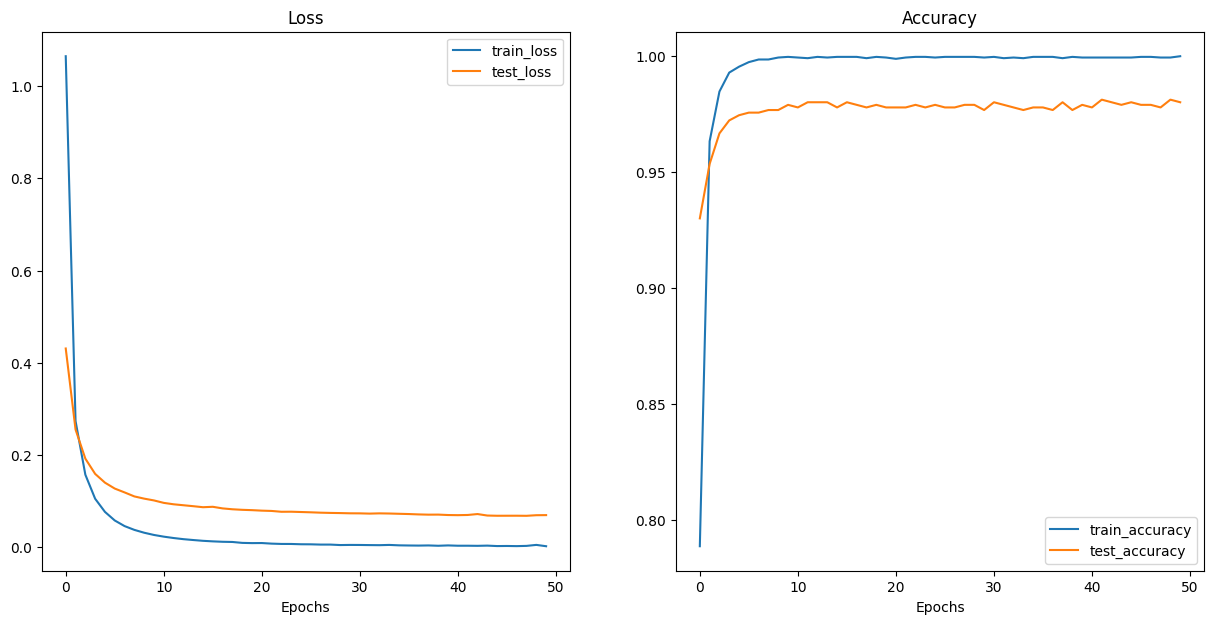

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py

from helper_functions import plot_loss_curves


# Plot our ViT model's loss curves
plot_loss_curves(pretrained_vit_results)

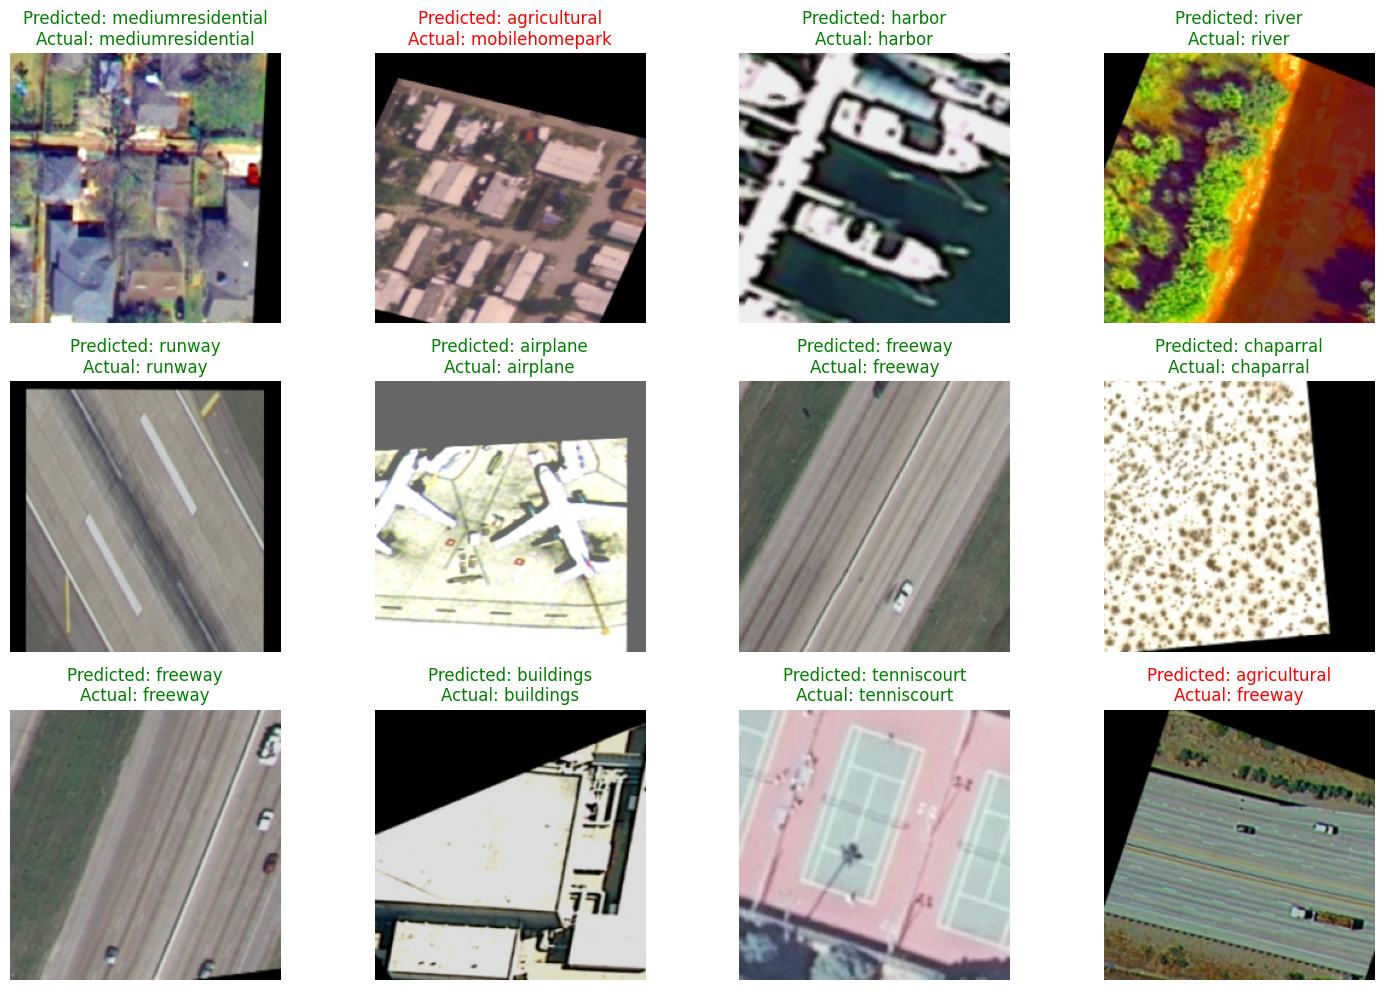

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# Assuming you have defined the device variable as "device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')"
# and class_names variable containing the names of the classes

# Move the model to the same device as the input data
pretrained_vit.to(device)

# Set the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 4

# Create a figure and axis objects for subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Convert the test dataset to a list and shuffle it to randomly select images
test_dataset_list = list(test_dataloader.dataset)
random.shuffle(test_dataset_list)

# Initialize a counter for displayed images
displayed_images = 0

# Iterate over individual images from the shuffled test dataset
for image, label in test_dataset_list:
    if displayed_images >= num_rows * num_cols:
        break

    # Move input data to the same device as the model
    image = image.unsqueeze(0).to(device)

    # Forward pass: compute predicted outputs by passing inputs to the model
    output = pretrained_vit(image)

    # Convert output to predicted label (assuming it is a class probability)
    _, predicted = torch.max(output, 1)  # Get the index with maximum probability

    # Get the class names for predicted and actual labels
    predicted_class_name = class_names[predicted.item()]
    actual_class_name = class_names[label]

    # Determine the color based on whether the prediction matches the actual label
    color = 'green' if predicted == label else 'red'

    # Plot the image along with its predicted label
    row_index = displayed_images // num_cols
    col_index = displayed_images % num_cols
    axs[row_index, col_index].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())  # Move image to CPU and convert to NumPy array for plotting
    axs[row_index, col_index].set_title(f'Predicted: {predicted_class_name}\nActual: {actual_class_name}', color=color)
    axs[row_index, col_index].axis('off')

    displayed_images += 1

plt.tight_layout()
plt.show()


**confusion matrix**

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


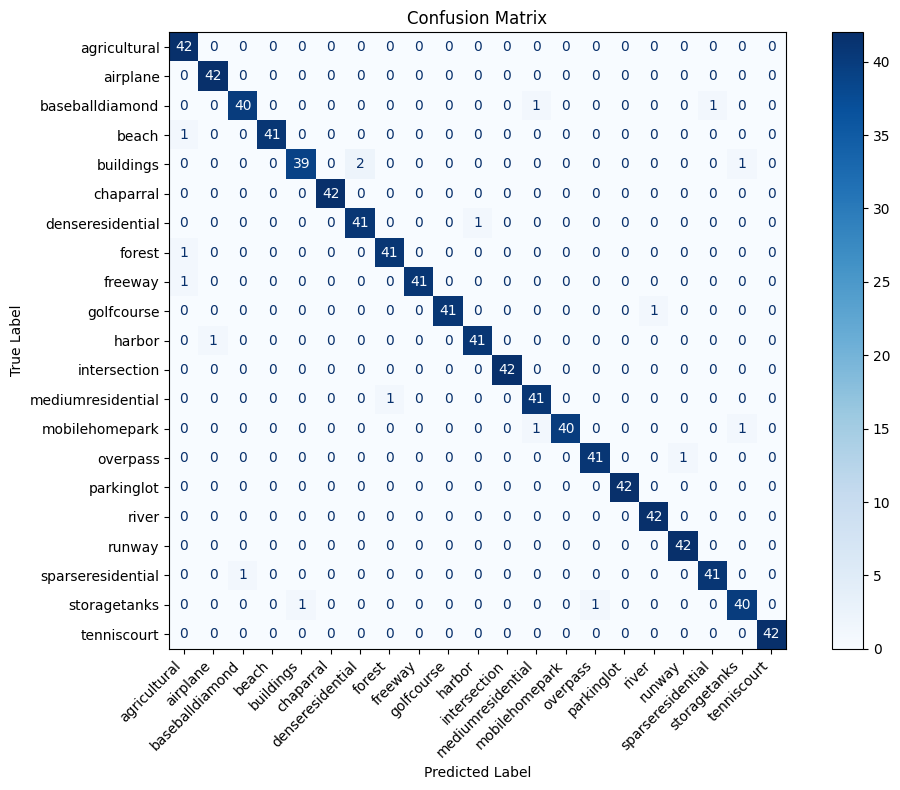

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Placeholder for storing true and predicted labels
true_labels_all = []
predicted_labels_all = []

# Iterate over the test dataset and make predictions
for batch in test_dataloader_pretrained:
    images, labels = batch
    images = images.to(device)

    # Get predictions for the batch
    with torch.no_grad():
        predictions = pretrained_vit(images)

    # Convert predictions and true labels to numpy arrays
    predicted_labels = predictions.argmax(dim=1).cpu().numpy()
    true_labels = labels.numpy()

    # Store true and predicted labels
    true_labels_all.extend(true_labels)
    predicted_labels_all.extend(predicted_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels_all, predicted_labels_all)

# Display confusion matrix with rotated x-axis labels
display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size if necessary
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure tight layout to prevent overlap
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_all, predicted_labels_all)

# Print precision, recall, and F1-score for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall   : {recall[i]:.2f}")
    print(f"  F1-score : {f1_score[i]:.2f}")
    print()


Class: agricultural
  Precision: 0.93
  Recall   : 1.00
  F1-score : 0.97

Class: airplane
  Precision: 0.98
  Recall   : 1.00
  F1-score : 0.99

Class: baseballdiamond
  Precision: 0.98
  Recall   : 0.95
  F1-score : 0.96

Class: beach
  Precision: 1.00
  Recall   : 0.98
  F1-score : 0.99

Class: buildings
  Precision: 0.97
  Recall   : 0.93
  F1-score : 0.95

Class: chaparral
  Precision: 1.00
  Recall   : 1.00
  F1-score : 1.00

Class: denseresidential
  Precision: 0.95
  Recall   : 0.98
  F1-score : 0.96

Class: forest
  Precision: 0.98
  Recall   : 0.98
  F1-score : 0.98

Class: freeway
  Precision: 1.00
  Recall   : 0.98
  F1-score : 0.99

Class: golfcourse
  Precision: 1.00
  Recall   : 0.98
  F1-score : 0.99

Class: harbor
  Precision: 0.98
  Recall   : 0.98
  F1-score : 0.98

Class: intersection
  Precision: 1.00
  Recall   : 1.00
  F1-score : 1.00

Class: mediumresidential
  Precision: 0.95
  Recall   : 0.98
  F1-score : 0.96

Class: mobilehomepark
  Precision: 1.00
  Recall 

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels_all, predicted_labels_all, target_names=class_names)

# Print the classification report
print(report)



                   precision    recall  f1-score   support

     agricultural       0.93      1.00      0.97        42
         airplane       0.98      1.00      0.99        42
  baseballdiamond       0.98      0.95      0.96        42
            beach       1.00      0.98      0.99        42
        buildings       0.97      0.93      0.95        42
        chaparral       1.00      1.00      1.00        42
 denseresidential       0.95      0.98      0.96        42
           forest       0.98      0.98      0.98        42
          freeway       1.00      0.98      0.99        42
       golfcourse       1.00      0.98      0.99        42
           harbor       0.98      0.98      0.98        42
     intersection       1.00      1.00      1.00        42
mediumresidential       0.95      0.98      0.96        42
   mobilehomepark       1.00      0.95      0.98        42
         overpass       0.98      0.98      0.98        42
       parkinglot       1.00      1.00      1.00       

In [ ]:
# Placeholder for sample images and true labels
sample_images = []  # List to store sample images
true_labels = []  # List to store true labels

# Iterate over the test dataset to collect sample images and true labels
for batch in test_dataloader_pretrained:
    images, labels = batch
    sample_images.extend(images)
    true_labels.extend(labels)

# Convert the list of sample images and true labels to PyTorch tensors
sample_images = torch.stack(sample_images)
true_labels = torch.tensor(true_labels)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


**SAVING MODEL**

In [ ]:
import tensorflow as tf

# Save path for the model architecture and weights
save_path = '/content/drive/MyDrive/VT/models/'

# Save the model architecture and weights to a single HDF5 file
tf.keras.models.save_model(pretrained_vit, save_path + 'VT_model.h5')


# EXPLAINABILITY


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Marvin_Owiny/data_vit/split_dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Marvin_Owiny/data_vit/split_dataset/test', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the best model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=len(train_dataset.classes))
model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device)
model.eval()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluate on training data
train_loss, train_correct, train_total = 0, 0, 0
train_preds, train_targets = [], []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

train_accuracy = accuracy_score(train_targets, train_preds)
train_precision = precision_score(train_targets, train_preds, average='weighted')
train_recall = recall_score(train_targets, train_preds, average='weighted')
train_f1 = f1_score(train_targets, train_preds, average='weighted')

# Evaluate on validation data
val_correct, val_total = 0, 0
val_preds, val_targets = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_preds)
val_precision = precision_score(val_targets, val_preds, average='weighted')
val_recall = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

# Print metrics
print(f'Train Loss: {train_loss / len(train_loader):.4f}')
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train F1 Score: {train_f1:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.1185
Train Accuracy: 0.9671
Validation Accuracy: 0.9875
Train Precision: 0.9675
Train Recall: 0.9671
Train F1 Score: 0.9671
Validation Precision: 0.9879
Validation Recall: 0.9875
Validation F1 Score: 0.9875


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git
import os
os.chdir(f'./Transformer-Explainability')

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377
Receiving objects: 100% (386/386), 3.85 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
import timm
from PIL import Image
from collections import OrderedDict
from modules.layers_ours import *
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP


CLS2IDX = {0: 'agricultural',
           1: 'airplane',
           2: 'baseballdiamond',
           3: 'beach',
           4: 'buildings',
           5: 'chaparral',
           6: 'denseresidential',
           7: 'forest',
           8: 'freeway',
           9: 'golfcourse',
           10: 'harbor',
           11: 'intersection',
           12: 'mediumresidential',
           13: 'mobilehomepark',
           14: 'overpass',
           15: 'parkinglot',
           16: 'river',
           17: 'runway',
           18: 'sparseresidential',
           19: 'storagetanks',
           20: 'tenniscourt'}


In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}

In [ ]:
mean = [0.485, 0.456, 0.406] # our images have three channels
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
])
resizing =  transforms.Resize((224,224))



In [ ]:
num_classes = 21
model =  vit_LRP(pretrained=True)
num_ftrs = model.head.in_features
model.head = Linear(num_ftrs, num_classes)
# load state dictionary
state_dict = torch.load('/content/best_vit_model.pth')
print("[Loading Weights to the Model]")
model.load_state_dict(state_dict)
model.cuda() # put model on GPU
model.eval()
attribution_generator = LRP(model)

[Loading Weights to the Model]


In [ ]:
import torch
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# Initialize the model
model = vit_LRP(pretrained=False, num_classes=21)  # Ensure num_classes matches your dataset
model = model.cuda()

# Load the saved state dictionary
state_dict = torch.load('/content/best_vit_model.pth')
model.load_state_dict(state_dict)

model.eval()  # Set the model to evaluation mode
attribution_generator = LRP(model)


def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])

    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [ ]:
ls /content/drive/MyDrive/Marvin_Owiny/data_vit/split_dataset/test/airplane/airplane_000482.png

/content/drive/MyDrive/Marvin_Owiny/data_vit/split_dataset/test/airplane/airplane_000482.png


Top 5 classes:
	1 : airplane        		value = 10.560	 prob = 99.8%
	2 : baseballdiamond 		value = 3.213	 prob = 0.1%
	4 : buildings       		value = 2.681	 prob = 0.0%
	6 : denseresidential		value = 1.978	 prob = 0.0%
	10 : harbor          		value = 1.893	 prob = 0.0%


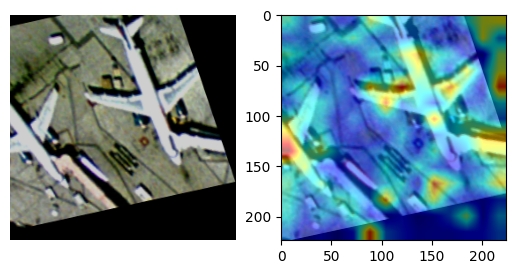

In [ ]:
image = Image.open('/content/drive/MyDrive/Marvin_Owiny/data_vit/split_dataset/test/airplane/airplane_000482.png')
airplane_image = transform(image)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');

output = model(airplane_image.unsqueeze(0).cuda())
print_top_classes(output)

# cat - the predicted class
airplane = generate_visualization(airplane_image)

airplane = generate_visualization(airplane_image, class_index=5)

axs[1].imshow(airplane);
#axs[1].axis('off');
